In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [18]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [3]:
base = '/n/home01/abeane/starbar/plots/bar_prop/data/'

bar_prop_N = h5.File(base + 'bar_prop_Nbody-lvl3.hdf5', mode='r')
bar_prop_S = h5.File(base + 'bar_prop_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [4]:
sn = read_snap(300, 1, parttype=None, fields=None)

In [17]:
bar_prop_S['bar_angle'][300]

3.674321517797914

In [19]:
center = np.array([200., 200., 200.])
bangle = bar_prop_S['bar_angle'][300]

pos = sn.part0.pos.value - center
pos = rotate_pos(pos, -bangle)

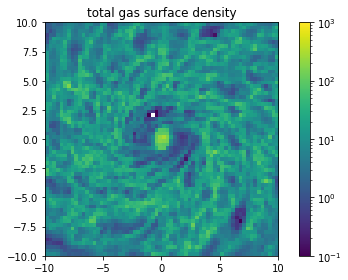

In [57]:
nres = 64

range_xy = [[-10, 10], [-10, 10]]

x = pos[:,0]
y = pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=1E10*sn.part0.mass.value)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1]-range_xy[1][0])/nres

dx = dx * 1E3
dy = dy * 1E3

heatmap_xy /= dx * dy

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin = 1E-1, vmax=1E3))
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
ax.set_title('total gas surface density')
fig.tight_layout()

plt.show()


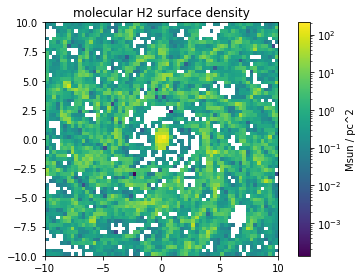

In [62]:
nres = 64

range_xy = [[-10, 10], [-10, 10]]

x = pos[:,0]
y = pos[:,1]
w = 1E10 * sn.part0.mass.value * sn.part0.MolecularHFrac

heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=w)

dx = (range_xy[0][1] - range_xy[0][0])/nres
dy = (range_xy[1][1]-range_xy[1][0])/nres

dx = dx * 1E3
dy = dy * 1E3

heatmap_xy /= dx * dy

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, label='Msun / pc^2')
ax.set_title('molecular H2 surface density')
fig.tight_layout()

plt.show()


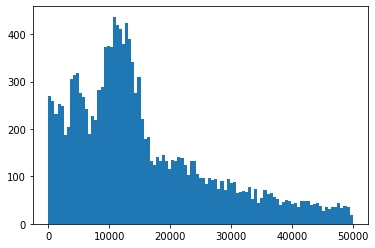

In [51]:
plt.hist(1E10*heatmap_xy[heatmap_xy > 0.0], bins=np.linspace(0, 1E10*0.000005, 100))›
plt.show()

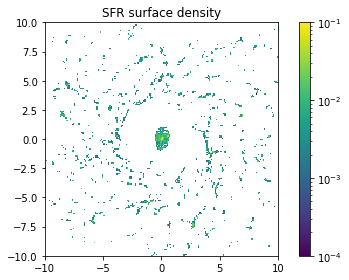

In [39]:
nres = 200

range_xy = [[-10, 10], [-10, 10]]

x = pos[:,0]
y = pos[:,1]
w = sn.part0.mass.value * sn.part0.sfr

heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=w)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
ax.set_title('SFR surface density')
fig.tight_layout()

plt.show()
